In [1]:
from ROOT import TH1F, TCanvas, TF1, gStyle

Welcome to JupyROOT 6.18/04


In [2]:
import os
import re

In [3]:
regex= re.compile(r'\d+')

In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [5]:
from functools import partial

In [6]:
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted'

In [74]:
error_distributions = os.path.join(saved_models, 'error_distributions')

In [7]:
root_path = partial(os.path.join, saved_models)

In [8]:
def get_params(file):
    epoch = int(regex.findall(os.path.split(file)[1].split('_')[3])[0])
    coef = int(regex.findall(os.path.split(file)[1].split('_')[4])[1])
    return epoch, coef

In [9]:
model_names = os.listdir(saved_models)

In [10]:
model_names

['predicted_unseen_6positions_85epochs_0.3coeff.npz',
 'predicted_testdata_6positions_35epochs_0.25coeff.npz',
 'predicted_unseen_6positions_20epochs_0.3coeff.npz',
 'predicted_unseen_6positions_65epochs_0.4coeff.npz',
 'predicted_unseen_6positions_65epochs_0.5coeff.npz',
 'predicted_testdata_6positions_5epochs_0.25coeff.npz',
 'predicted_unseen_6positions_10epochs_0.75coeff.npz',
 'predicted_testdata_6positions_70epochs_0.6coeff.npz',
 'predicted_testdata_6positions_70epochs_0.7coeff.npz',
 'predicted_unseen_6positions_30epochs_0.3coeff.npz',
 'predicted_unseen_6positions_75epochs_0.5coeff.npz',
 'predicted_unseen_6positions_75epochs_0.4coeff.npz',
 'predicted_testdata_6positions_65epochs_0.25coeff.npz',
 'predicted_testdata_6positions_100epochs_0.25coeff.npz',
 'predicted_unseen_6positions_95epochs_0.3coeff.npz',
 'predicted_testdata_6positions_60epochs_0.7coeff.npz',
 'predicted_testdata_6positions_60epochs_0.6coeff.npz',
 'predicted_unseen_6positions_80epochs_0.25coeff.npz',
 'pred

In [11]:
def get_fnames(coeff, prefix='Trained'):
    idx_coef = 6 if prefix=='Trained' else 4
    idx_epoch = 5 if prefix =='Trained' else 3
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith(prefix):
            if regex.findall(fname.split("_")[idx_coef])[1]==str(coeff):
                epoch = int(regex.findall(fname.split("_")[idx_epoch])[0]) 
                epochs.append(epoch)
                if int(regex.findall(fname.split("_")[idx_epoch])[0])==epoch:
                    f_list.append(fname)
    
    return np.array(f_list)[np.argsort(epochs)], np.sort(epochs)

In [115]:
def gaus_fit_avg(coeff, epoch, fname_keyword, out_file_key, save_file=True,  
                 n_bins = 10, histo_min = -1.0, histo_max = 1.0, print_sigma=True):
    
    filelist, epochs = get_fnames(coeff, prefix=fname_keyword)
    model = filelist[int(np.argwhere(epochs==epoch)[0])]

    data = np.load(root_path(model))
    true = data['true']
    preds = data['pred']

    mean = np.mean(true-preds)
    histo = TH1F("{}".format(fname_keyword),
                 "Distribution of prediction errors for r-UNet estimations", 
                 n_bins,histo_min,histo_max)
    for i in (true-preds):
        histo.Fill(i)
    canvas = TCanvas()
    f = TF1("f","gaus")
    f.FixParameter(1,mean)

    histo.Fit(f, "S")
    histo.GetXaxis().SetTitle("prediction error (mm)");
    yax=histo.GetYaxis()
    yax.SetLimits(0,500)
    #histo.SetAxisRange(0, 500,"y")
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(0)
    gStyle.SetStatY(0.9)
    gStyle.SetStatX(0.9)
    gStyle.SetStatW(0.15)
    gStyle.SetStatH(0.15)
    histo.Draw()
    canvas.Draw()
    if save_file:
        canvas.SaveAs(os.path.join(error_distributions,
                                   '_'.join(["error_distribution",out_file_key])+".png"))
    if print_sigma:
        sigma = f.GetParameter(2)
        err = f.GetParError(2)
        print('Sigma: {:.5f} ± {:.5f}'.format(sigma, err))
    return histo, canvas, sigma, err

Sigma: 0.19256 ± 0.00237
 FCN=594.523 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=4.37405e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.25415e+02   2.66464e+00   2.75729e-02   2.60015e-06
   2  Mean        -1.70283e-01     fixed    
   3  Sigma        1.92561e-01   2.37020e-03   4.20068e-05  -6.28711e-03


Warning in <TROOT::Append>: Replacing existing TH1: predicted_unseen (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/error_distribution_error_distr_avg.png has been created


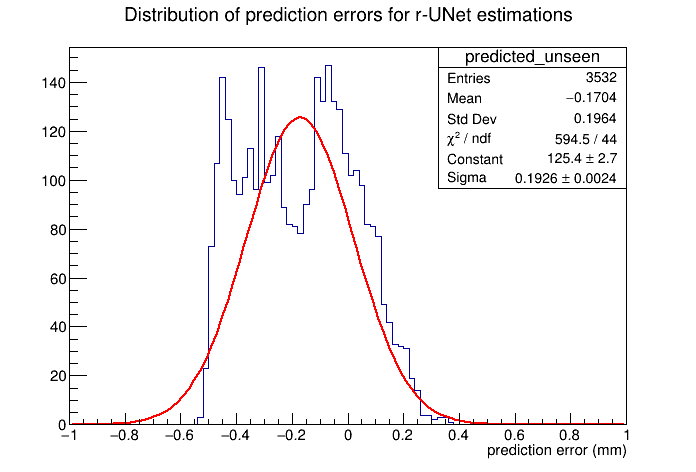

In [110]:
h, c, sigma, err = gaus_fit_avg(4, 100, 'predicted_unseen', 'error_distr_avg', n_bins=100, save_file=True)

Sigma: 0.05063 ± 0.00104


(<ROOT.TH1F object ("predicted_testdata") at 0x558cc4d2d830>,
 <ROOT.TCanvas object ("c1_n15") at 0x558cc4f513e0>,
 0.0506315577080345,
 0.0010361594255369998)

 FCN=11.3062 FROM MIGRAD    STATUS=CONVERGED      38 CALLS          39 TOTAL
                     EDM=2.31725e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.68447e+02   6.19427e+00   8.82457e-03   1.31112e-04
   2  Mean         1.16667e-03     fixed    
   3  Sigma        5.06316e-02   1.03616e-03   9.56571e-06   5.46098e-02


Warning in <TROOT::Append>: Replacing existing TH1: predicted_testdata (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/error_distribution_error_distr_avg.png has been created


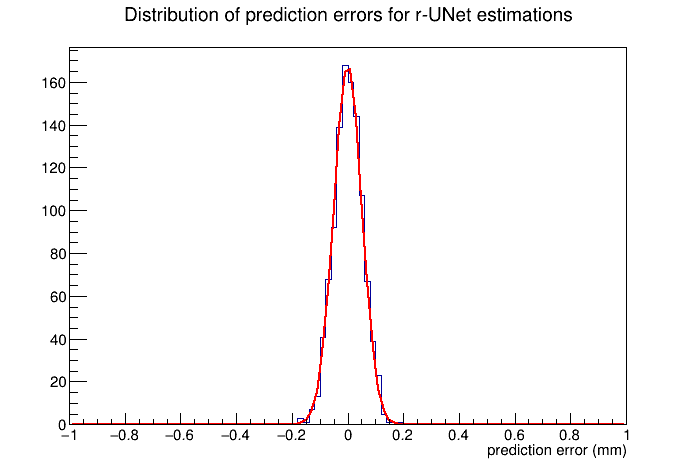

In [116]:
gaus_fit_avg(4, 100, 'predicted_testdata', 'error_distr_avg', n_bins=100, save_file=True)

In [18]:
def idx_mse(dist, true_arr, preds_arr):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [117]:
def gaus_fit_dist(coeff, epoch, fname_keyword, distances, out_file_key, save_file=False, 
                  n_bins = 10, histo_min = -1.0, histo_max = 1.0, print_sigma=True):
    filelist, epochs = get_fnames(coeff, prefix=fname_keyword)
    model = filelist[int(np.argwhere(epochs==epoch)[0])]

    data = np.load(root_path(model))
    
    true = data['true']
    preds = data['pred']
    sigmas = []
    errors = []
    for dist in distances:
        histo=None
        canvas=None
        idx = idx_mse(dist, preds_arr=preds, true_arr=true)[0]
        y_true = true[idx]
        y_pred = preds[idx]
        
        mean = np.mean(y_true-y_pred)
        histo = TH1F("{}_{}mm".format(fname_keyword, dist),
                 "Distribution of prediction errors for r-UNet estimations", 
                 n_bins,histo_min,histo_max)
        for i in (y_true-y_pred):
            histo.Fill(i)
    
        canvas = TCanvas()
        f = TF1("f","gaus")
        f.FixParameter(1,mean)

        histo.Fit(f, "S")
        histo.GetXaxis().SetTitle("prediction error (mm)");
        yax=histo.GetYaxis()
        yax.SetLimits(0,500)
        #histo.SetAxisRange(0, 500,"y")
        #gStyle.SetOptStat("nmR")
        gStyle.SetOptFit(0)
        gStyle.SetStatY(0.9)
        gStyle.SetStatX(0.9)
        gStyle.SetStatW(0.15)
        gStyle.SetStatH(0.15)
        histo.Draw()
        canvas.Draw()
        if save_file:
            out_file_path = os.path.join(error_distributions,
                                   '_'.join(["TEST_{}mm".format(dist),out_file_key])+".png")
            print("saving as: {}".format(out_file_path))
            canvas.SaveAs(out_file_path)
        if print_sigma:
            sigma=f.GetParameter(2)
            err= f.GetParError(2)
            print('Sigma: {:.5f} ± {:.5f}'.format(sigma, err))
            sigmas.append(sigma)
            errors.append(err)
    return histo, canvas, sigmas, errors

In [118]:
epoch= 100
coef = 4

In [119]:
test_distances = [2,4,10,20,25,35]

In [120]:
unseen_dist = [1,3,15,30]

1 0.17141122917721116
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_1mm_error_distribution_unseen.png
Sigma: 0.05768 ± 0.00141
3 0.014501266429676845
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_3mm_error_distribution_unseen.png
Sigma: 0.08846 ± 0.00280
15 0.007489702083939846
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_15mm_error_distribution_unseen.png
Sigma: 0.05380 ± 0.00131
30 0.0729172566264323
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_30mm_error_distribution_unseen.png
Sigma: 0.07024 ± 0.00183
 FCN=115.801 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=4.91001e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                   

Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_1mm_error_distribution_unseen.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_3mm_error_distribution_unseen.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_15mm_error_distribution_unseen.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_30mm_error_distribution_unseen.png has been created


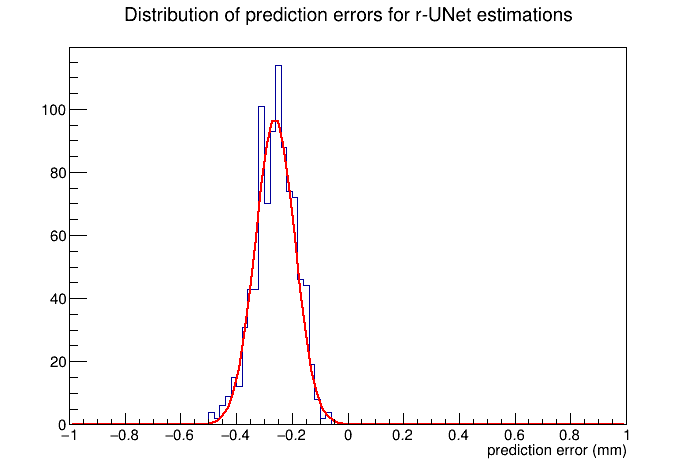

In [121]:
h, c, sigmas_unseen, errors_unseen = gaus_fit_dist(epoch=epoch, coeff=coef, fname_keyword='predicted_unseen', distances=unseen_dist,
             out_file_key='error_distribution_unseen', n_bins=100, save_file=True );

2 0.0027615689558937936
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_2mm_error_distribution_testdata.png
Sigma: 0.04631 ± 0.00280
4 0.0025889254369755505
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_4mm_error_distribution_testdata.png
Sigma: 0.04896 ± 0.00275
10 0.0026983519895451076
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_10mm_error_distribution_testdata.png
Sigma: 0.05020 ± 0.00332
20 0.0026731691746057808
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_20mm_error_distribution_testdata.png
Sigma: 0.04532 ± 0.00301
25 0.002443215590108416
saving as: /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_25mm_error_distribution_testdata

Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_2mm_error_distribution_testdata.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_4mm_error_distribution_testdata.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_10mm_error_distribution_testdata.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_20mm_error_distribution_testdata.png has been created
Info in <TCanvas::Print>: png file /storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/predicted/error_distributions/TEST_25mm_error_distribution_testdata.png has been created
Warning in <

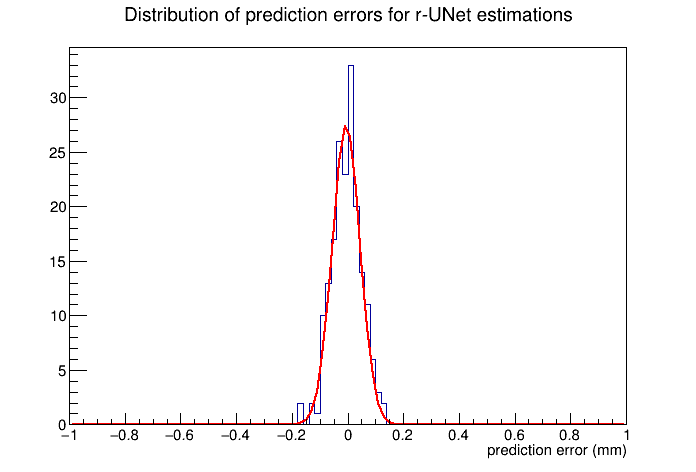

In [122]:
h, c, sigmas_test, errors_test= gaus_fit_dist(epoch=epoch, coeff=coef, fname_keyword='predicted_testdata', distances=test_distances,
             out_file_key='error_distribution_testdata', n_bins=100, save_file=True  );

In [25]:
sigmas_test

[0.046306701387995926,
 0.0489562441817401,
 0.050203148664655924,
 0.04532158598718315,
 0.052855559755730384,
 0.049800973831860974]

In [26]:
errors_test

[0.0027957593324761977,
 0.0027539716995318153,
 0.003320426879259996,
 0.0030148841534009367,
 0.004148260591782322,
 0.003000711824394691]

In [27]:
sigmas_unseen

[0.05768219465446542,
 0.088461958672909,
 0.05379675523105381,
 0.07023595457250292]

In [28]:
errors_unseen

[0.0014063135894952193,
 0.0028034078427764814,
 0.00131328244057375,
 0.00182904722971957]

In [29]:
sigmas = sigmas_test+sigmas_unseen

In [30]:
errors = errors_test+errors_unseen

In [31]:
distances = test_distances+unseen_dist

In [32]:
import matplotlib.pyplot as plt

In [125]:
print(np.min(sigmas_unseen), np.max(sigmas_unseen))

0.05379675523105381 0.088461958672909


In [126]:
print(np.min(sigmas_test), np.max(sigmas_test))

0.04532158598718315 0.052855559755730384


In [33]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

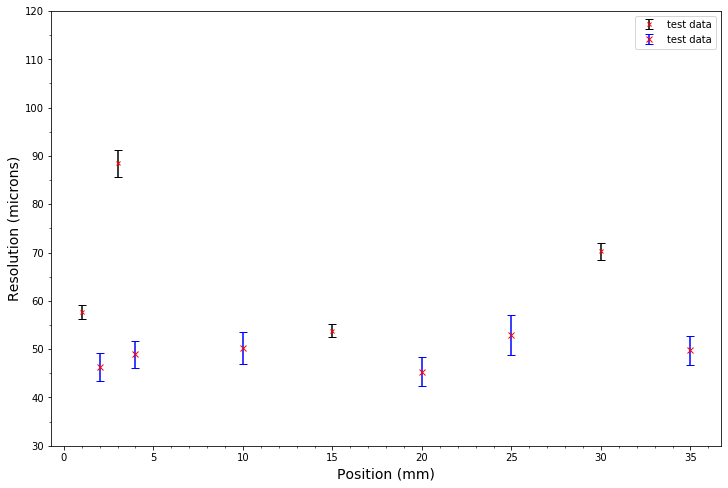

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(np.sort(unseen_dist), np.array(sigmas_unseen)[np.argsort(unseen_dist)]*1000,
            np.array(errors_unseen)[np.argsort(unseen_dist)]*1000,
            fmt='x', capsize=4, c='red',ecolor='k', label='test data', markersize=4)
ax.errorbar(np.sort(test_distances), np.array(sigmas_test)[np.argsort(test_distances)]*1000,
            np.array(errors_test)[np.argsort(test_distances)]*1000,
            fmt='x', capsize=4, c='red',ecolor='b', label='test data')
ax.set_ylabel("Resolution (microns)", size=14)
ax.set_xlabel("Position (mm)", size=14)
ax.set_ylim(30,120)
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig("resolution_60_100.png")

In [36]:
distances = test_distances+unseen_dist

In [37]:
def mse_positions(coeff, epoch, fname_keyword, dist = unseen_dist):
    
    filelist, epochs = get_fnames(coeff, prefix=fname_keyword)
    model = filelist[int(np.argwhere(epochs==epoch)[0])]

    data = np.load(root_path(model))
    y_true = data['true']
    y_pred = data['pred']
    print(model)
    mse=[]
    avg=[]
    std=[]
    for d in dist:
        idx = idx_mse(d, preds_arr=y_pred, true_arr=y_true)[0]
        y_true_d = y_true[idx]
        y_pred_d = y_pred[idx]
        mse_d = mean_squared_error(y_true_d, y_pred_d)
        avg_pred = np.mean(y_pred_d)
        std_pred = np.std(y_pred_d)
        mse.append(mse_d)
        avg.append(avg_pred)
        std.append(std_pred)
    return mse, avg, std

In [38]:
mse_unseen, avg_unseen, std_unseen = mse_positions(4, 100, 'predicted_unseen')

predicted_unseen_6positions_100epochs_0.4coeff.npz
1 0.17141122917721116
3 0.014501266429676845
15 0.007489702083939846
30 0.0729172566264323


In [39]:
mse_test, avg_test, std_test = mse_positions(4, 100, 'predicted_testdata', dist=test_distances)

predicted_testdata_6positions_100epochs_0.4coeff.npz
2 0.0027615689558937936
4 0.0025889254369755505
10 0.0026983519895451076
20 0.0026731691746057808
25 0.002443215590108416
35 0.002911549894494778


In [40]:
std = mse_test+mse_unseen

In [41]:
avg = avg_test+avg_unseen

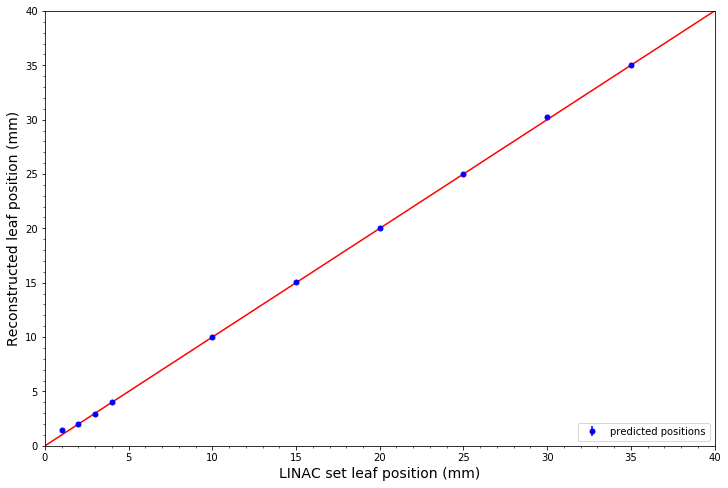

In [61]:
fig, ax = plt.subplots(figsize=(12,8))

ax.errorbar(np.sort(distances), np.array(avg)[np.argsort(distances)], 
                                np.array(std)[np.argsort(distances)], fmt='o',
            markersize=5, capsize=0, c='b',ecolor='b', label='predicted positions')
ax.plot(np.arange(0,50), np.arange(0,50),c='red')
#plt.xticks(np.arange(0,40,5))
#plt.yticks(np.arange(0,40,5))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylabel("Reconstructed leaf position (mm)", size=14)
ax.set_xlabel("LINAC set leaf position (mm)", size=14)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.legend(loc='lower right')


plt.savefig("reconstructed_vs_true_linear.png")

In [151]:
np.array(avg)[np.argsort(distances)]

array([ 1.5169474,  1.9900761,  2.9001012,  4.0159717, 10.055413 ,
       15.365527 , 20.09631  , 25.107346 , 30.363537 , 35.14626  ],
      dtype=float32)